In [1]:
from datetime import datetime
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
import torch
import pandas as pd
import nltk




---





---



#preprocessing




In [2]:
post_df = pd.read_csv("posts_res.csv")

In [3]:
post_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7267 non-null   int64  
 1   id                7267 non-null   object 
 2   headline          7267 non-null   object 
 3   geoLocationName   6862 non-null   object 
 4   summary           6535 non-null   object 
 5   industryName      7266 non-null   object 
 6   followers         7267 non-null   float64
 7   connections       7267 non-null   float64
 8   text              7267 non-null   object 
 9   likes             7267 non-null   float64
 10  comments          7267 non-null   float64
 11  shares            7267 non-null   float64
 12  number_of_images  7267 non-null   float64
 13  Unnamed: 13       0 non-null      float64
 14  prediction        7267 non-null   object 
dtypes: float64(7), int64(1), object(7)
memory usage: 851.7+ KB




---



In [4]:
import re

def remove_emojis(text):
  # Regular expression to match all emojis
  emoji_pattern = re.compile("["
                          u"\U0001F600-\U0001F64F"  # emoticons
                          u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                          u"\U0001F680-\U0001F6FF"  # transport & map symbols
                          u"\U0001F700-\U0001F77F"  # alchemical symbols
                          u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                          u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                          u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                          u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                          u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                          u"\U00002702-\U000027B0"  # Dingbats
                          u"\U000024C2-\U0001F251"
                          "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', text)  # Replace emojis with empty string

# Apply the function to each text entry
post_df['text'] = post_df['text'].apply(remove_emojis)

#only emojis
post_df = post_df[post_df['text'].apply(lambda x: any(char.isalnum() for char in x))]


#Remove text shorter than 4 words
post_df['short_sentence'] = post_df['text'].apply(lambda x: len(x.split()))
post_df = post_df[post_df['short_sentence'] >= 4].drop('short_sentence', axis=1)

# Only relevant records
post_df = post_df[post_df['prediction'] == 'Other Topics']
post_df = post_df.drop(['prediction', 'Unnamed: 13', 'Unnamed: 0'], axis=1)


<ipython-input-4-69f370a66eaa>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  post_df['short_sentence'] = post_df['text'].apply(lambda x: len(x.split()))




---



**Decision rule**


In [5]:
#decision rule
post_df['popularity_score'] = ((post_df['likes'] * 1) + (post_df['comments'] * 3) + (post_df['shares'] * 9)) / (np.log(post_df['followers'] + 1) + 1)
post_df['popularity_score'] = post_df['popularity_score'].astype(int)
post_df['popularity_score'] = (post_df['popularity_score'] - post_df['popularity_score'].min()) / (post_df['popularity_score'].max() - post_df['popularity_score'].min())

# Calculate the mean and standard deviation
mean_popularity = post_df['popularity_score'].mean()
std_dev_popularity = post_df['popularity_score'].std()

# Calculate the threshold
threshold = mean_popularity + 0.5*std_dev_popularity

# Tagging the posts
post_df['popularity_score'] = np.where(post_df['popularity_score'] > threshold, 1.0, 0.0)

post_df.head(10)

,id,headline,geoLocationName,summary,industryName,followers,connections,text,likes,comments,shares,number_of_images,popularity_score
0,caressa-grooms-4b0477224,Operations Data Analyst at Island Mountain Dev...,"Billings, Montana",NaN,Financial Services,28.0,27.0,just finished the course “mel robbins on confi...,0.0,0.0,0.0,0.0,0.0
1,caressa-grooms-4b0477224,Operations Data Analyst at Island Mountain Dev...,"Billings, Montana",NaN,Financial Services,28.0,27.0,just finished the course “building resilience”...,0.0,0.0,0.0,0.0,0.0
2,caressa-grooms-4b0477224,Operations Data Analyst at Island Mountain Dev...,"Billings, Montana",NaN,Financial Services,28.0,27.0,just finished the course “getting things done”...,0.0,0.0,0.0,0.0,0.0
4,caressa-grooms-4b0477224,Operations Data Analyst at Island Mountain Dev...,"Billings, Montana",NaN,Financial Services,28.0,27.0,just finished the course “the six morning habi...,0.0,0.0,0.0,0.0,0.0
7,lavanya-bandari-b6219710,Architect | Product Strategy | Data Scientist ...,"San Francisco, California",Summary:\n\nCurrently architecting Solutions i...,Information Technology & Services,641.0,500.0,best captured our west sa team in one frame!,73.0,1.0,0.0,1.0,1.0
9,lavanya-bandari-b6219710,Architect | Product Strategy | Data Scientist ...,"San Francisco, California",Summary:\n\nCurrently architecting Solutions i...,Information Technology & Services,641.0,500.0,"re:invent vibes - meetings customers, learning...",59.0,3.0,0.0,3.0,1.0
10,lavanya-bandari-b6219710,Architect | Product Strategy | Data Scientist ...,"San Francisco, California",Summary:\n\nCurrently architecting Solutions i...,Information Technology & Services,641.0,500.0,excellent session from brian sevy extensiv tod...,14.0,2.0,1.0,6.0,0.0
11,lavanya-bandari-b6219710,Architect | Product Strategy | Data Scientist ...,"San Francisco, California",Summary:\n\nCurrently architecting Solutions i...,Information Technology & Services,641.0,500.0,i was very impressed by fullpower-ai's custome...,29.0,3.0,1.0,3.0,0.0
12,jeff-goulait-a002073,Vice President @ Bridg | SaaS & Digital Media ...,"Cincinnati, Ohio","20+ years as an entrepreneurial, growth minded...",Consumer Goods,1319.0,500.0,come see jennifer ortner and i today at path t...,31.0,0.0,0.0,0.0,0.0
13,jeff-goulait-a002073,Vice President @ Bridg | SaaS & Digital Media ...,"Cincinnati, Ohio","20+ years as an entrepreneurial, growth minded...",Consumer Goods,1319.0,500.0,i was struck by the ubiquity of apple's 'scary...,6.0,0.0,0.0,1.0,0.0


**missing:**

Filling Missing industryName with 'Other': Assigning 'Other' to missing industry names ensures every data point is included in analyses without introducing bias. It acknowledges the diversity of industries while maintaining data completeness.

Filling Missing geoLocationName with 'Other': By labeling unspecified locations as 'Other', all records are retained for analysis, preventing potential biases and allowing for a comprehensive dataset, even without specific location details.

Handling Missing about Text with Zero Vectors: For missing 'about' text, using zero vectors as placeholders in embeddings allows the model to recognize the absence of data without bias, ensuring consistent processing across all entries.

In [6]:
#fill NAN with other
post_df['geoLocationName'] = post_df['geoLocationName'].fillna('Other')
post_df['industryName'] = post_df['industryName'].fillna('Other')

# summary (about) filled in part of creating embeddings

Label Imbalance Check:

In [7]:
count_popularity_1 = (post_df['popularity_score'] == 1.0).sum()
print(f"The tagging ratio of the successful posts: {count_popularity_1/len(post_df)}")

The tagging ratio of the successful posts: 0.12356610988126383


**Text embeddings:**

In [8]:
# Initialize TinyBERT tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')
model = AutoModel.from_pretrained('huawei-noah/TinyBERT_General_4L_312D')

# Function to encode a batch of text using TinyBERT, handling empty strings
def encode_text_batch_with_tinybert(texts):
  embeddings = []
  for text in texts:
    if text is not None and text == text and text.strip():
      encoded_input = tokenizer(text, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
      with torch.no_grad():
        output = model(**encoded_input)
      embeddings.append(output.last_hidden_state[:, 0, :].numpy())  # Get embeddings for [CLS] token
    else:
      # Return a zero vector for empty strings or strings that contain only whitespace
      embeddings.append(np.zeros(model.config.hidden_size))
  return np.vstack(embeddings)

# Function to process data in batches and apply the encoding function
def process_in_batches(data, batch_size, column_name):
  # Initialize an empty list to store the embeddings
  embeddings = []

  # Process each batch
  for i in range(0, len(data), batch_size):
    batch = data[i:i + batch_size]
    batch_embeddings = encode_text_batch_with_tinybert(batch)
    embeddings.extend(batch_embeddings)

  # Assign the embeddings to the DataFrame
  post_df[column_name] = embeddings

# Apply the function to each text column
process_in_batches(post_df['text'].tolist(), 1000, 'post_embeddings')
process_in_batches(post_df['summary'].tolist(), 1000, 'about_embeddings')
process_in_batches(post_df['headline'].tolist(), 1000, 'headline_embeddings')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/409 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/62.7M [00:00<?, ?B/s]

**industryName:**
We used the mapping for industries from exercise 2, since the mapping was for companies and not for profiles, we added more mappings, so we got 12 mappings and another one for missing ones named "others"

In [9]:
meta_industries_12 = {
    'Furniture and Home Furnishings Manufacturing': 'Manufacturing',
    'Investment Banking': 'Financial and Investment',
    'Architecture and Planning': 'Services',
    'Wholesale': 'Services',
    'Travel Arrangements': 'Services',
    'Ranching': 'Miscellaneous',
    'Hospitals and Health Care': 'Healthcare and Medical',
    'Book and Periodical Publishing': 'Services',
    'Printing Services': 'Services',
    'Professional Training and Coaching': 'Services',
    'Computers and Electronics Manufacturing': 'Manufacturing',
    'Shipbuilding': 'Manufacturing',
    'Public Policy Offices': 'Government and Public Policy',
    'Software Development': 'Technology',
    'Outsourcing and Offshoring Consulting': 'Services',
    'Retail Groceries': 'Retail and Consumer Goods',
    'Education Administration Programs': 'Education and Training',
    'Plastics Manufacturing': 'Manufacturing',
    'Renewable Energy Semiconductor Manufacturing': 'Manufacturing',
    'Computer Networking Products': 'Technology',
    'Events Services': 'Services',
    'Information Services': 'Services',
    'Food and Beverage Services': 'Services',
    'Semiconductor Manufacturing': 'Manufacturing',
    'Business Consulting and Services': 'Services',
    'Insurance': 'Services',
    'Financial Services': 'Services',
    'Wireless Services': 'Services',
    'Computer Hardware Manufacturing': 'Technology',
    'Public Safety': 'Services',
    'Maritime Transportation': 'Transportation and Logistics',
    'Tobacco Manufacturing': 'Manufacturing',
    'Writing and Editing': 'Services',
    'Veterinary Services': 'Services',
    'Staffing and Recruiting': 'Services',
    'Accounting': 'Services',
    'International Affairs': 'Government and Public Policy',
    'Spectator Sports': 'Miscellaneous',
    'Glass, Ceramics and Concrete Manufacturing': 'Manufacturing',
    'Chemical Manufacturing': 'Manufacturing',
    'Mining': 'Miscellaneous',
    'E-Learning Providers': 'Technology',
    'Security and Investigations': 'Services',
    'Translation and Localization': 'Services',
    'Automation Machinery Manufacturing': 'Technology',
    'Computer and Network Security': 'Technology',
    'Political Organizations': 'Government and Public Policy',
    'Environmental Services': 'Government and Public Policy',
    'Oil and Gas': 'Miscellaneous',
    'Real Estate': 'Real Estate and Construction',
    'Think Tanks': 'Government and Public Policy',
    'Executive Offices': 'Miscellaneous',
    'Law Practice': 'Services',
    'Nanotechnology Research': 'Miscellaneous',
    'International Trade and Development': 'Government and Public Policy',
    'Personal Care Product Manufacturing': 'Manufacturing',
    'Philanthropic Fundraising Services': 'Services',
    'Entertainment Providers': 'Media and Entertainment',
    'Market Research': 'Media and Entertainment',
    'Movies, Videos, and Sound': 'Media and Entertainment',
    'Sporting Goods Manufacturing': 'Manufacturing',
    'Graphic Design': 'Services',
    'Technology, Information and Internet': 'Technology',
    'IT Services and IT Consulting': 'Technology',
    'Retail Office Equipment': 'Retail and Consumer Goods',
    'Wholesale Import and Export': 'Services',
    'Capital Markets': 'Financial and Investment',
    'Law Enforcement': 'Services',
    'Freight and Package Transportation': 'Transportation and Logistics',
    'Industrial Machinery Manufacturing': 'Manufacturing',
    'Non-profit Organizations': 'Miscellaneous',
    'Retail Art Supplies': 'Retail and Consumer Goods',
    'Animation and Post-production': 'Media and Entertainment',
    'Transportation, Logistics, Supply Chain and Storage': 'Transportation and Logistics',
    'Aviation and Aerospace Component Manufacturing': 'Transportation and Logistics',
    'Fundraising': 'Financial and Investment',
    'Railroad Equipment Manufacturing': 'Transportation and Logistics',
    'Construction': 'Real Estate and Construction',
    'Investment Management': 'Financial and Investment',
    'Utilities': 'Miscellaneous',
    'Retail Luxury Goods and Jewelry': 'Retail and Consumer Goods',
    'Warehousing and Storage': 'Transportation and Logistics',
    'Media Production': 'Media and Entertainment',
    'Gambling Facilities and Casinos': 'Media and Entertainment',
    'Defense and Space Manufacturing': 'Manufacturing',
    'Facilities Services': 'Services',
    'Government Relations Services': 'Government and Public Policy',
    'Advertising Services': 'Media and Entertainment',
    'Paper and Forest Product Manufacturing': 'Manufacturing',
    'Packaging and Containers Manufacturing': 'Manufacturing',
    'Telecommunications': 'Technology',
    'Medical Equipment Manufacturing': 'Healthcare and Medical',
    'Beverage Manufacturing': 'Manufacturing',
    'Restaurants': 'Retail and Consumer Goods',
    'Leasing Non-residential Real Estate': 'Real Estate and Construction',
    'Newspaper Publishing': 'Media and Entertainment',
    'Armed Forces': 'Miscellaneous',
    'Appliances, Electrical, and Electronics Manufacturing': 'Manufacturing',
    'Hospitality': 'Services',
    'Pharmaceutical Manufacturing': 'Healthcare and Medical',
    'Research Services': 'Services',
    'Retail Apparel and Fashion': 'Retail and Consumer Goods',
    'Photography': 'Media and Entertainment',
    'Wellness and Fitness Services': 'Services',
    'Truck Transportation': 'Transportation and Logistics',
    'Consumer Services': 'Services',
    'Wholesale Building Materials': 'Services',
    'Human Resources Services': 'Services',
    'Airlines and Aviation': 'Transportation and Logistics',
    'Machinery Manufacturing': 'Manufacturing',
    'Individual and Family Services': 'Services',
    'Motor Vehicle Manufacturing': 'Manufacturing',
    'Performing Arts': 'Media and Entertainment',
    'Museums, Historical Sites, and Zoos': 'Media and Entertainment',
    'Broadcast Media Production and Distribution': 'Media and Entertainment',
    'Banking': 'Financial and Investment',
    'Recreational Facilities': 'Miscellaneous',
    'Government Administration': 'Government and Public Policy',
    'Public Relations and Communications Services': 'Media and Entertainment',
    'Fisheries': 'Miscellaneous',
    'Medical Practices': 'Healthcare and Medical',
    'Religious Institutions': 'Miscellaneous',
    'Online Audio and Video Media': 'Media and Entertainment',
    'Artists and Writers': 'Miscellaneous',
    'Biotechnology Research': 'Healthcare and Medical',
    'Legal Services': 'Services',
    'Retail': 'Retail and Consumer Goods',
    'Civil Engineering': 'Services',
    'Libraries': 'Miscellaneous',
    'Alternative Dispute Resolution': 'Miscellaneous',
    'Manufacturing': 'Miscellaneous',
    'Design Services': 'Services',
    'Dairy Product Manufacturing': 'Manufacturing',
    'Higher Education': 'Education and Training',
    'Civic and Social Organizations': 'Miscellaneous',
    'Textile Manufacturing': 'Manufacturing',
    'Venture Capital and Private Equity Principals': 'Financial and Investment',
    'Mental Health Care': 'Healthcare and Medical',
    'Musicians': 'Media and Entertainment',
    'Farming': 'Miscellaneous',
    'Computer Games': 'Media and Entertainment',
    'Strategic Management Services': 'Services',
    'Food and Beverage Manufacturing': 'Manufacturing',
    'Primary and Secondary Education': 'Education and Training',
    'Alternative Medicine': 'Healthcare and Medical',
    'Legislative Offices': 'Services',
    'Administration of Justice': 'Services',
    'Mobile Gaming Apps': 'Media and Entertainment'
}

additional_mapping = {
    'Information Technology & Services': 'Technology',
    'Consumer Goods': 'Retail and Consumer Goods',
    'Food Production': 'Manufacturing',
    'Computer Software': 'Technology',
    'Hospital & Health Care': 'Healthcare and Medical',
    'Biotechnology': 'Healthcare and Medical',
    'Food & Beverages': 'Retail and Consumer Goods',
    'Human Resources': 'Services',
    'Primary/Secondary Education': 'Education and Training',
    'Defense & Space': 'Miscellaneous',
    'Aviation & Aerospace': 'Transportation and Logistics',
    'Management Consulting': 'Services',
    'Semiconductors': 'Technology',
    'Transportation/Trucking/Railroad': 'Transportation and Logistics',
    'Non-profit Organization Management': 'Miscellaneous',
    'Internet': 'Technology',
    'E-learning': 'Education and Training',
    'Electrical & Electronic Manufacturing': 'Manufacturing',
    'Financial and Investment': 'Financial and Investment',
    'Real Estate and Construction': 'Real Estate and Construction',
    'Medical Practice': 'Healthcare and Medical',
    'Military': 'Miscellaneous',
    'Logistics & Supply Chain': 'Transportation and Logistics',
    'Airlines/Aviation': 'Transportation and Logistics',
    'Automotive': 'Manufacturing',
    'Professional Training & Coaching': 'Services',
    'Executive Office': 'Miscellaneous',
    'Entertainment': 'Media and Entertainment',
    'Staffing & Recruiting': 'Services',
    'Apparel & Fashion': 'Retail and Consumer Goods',
    'Computer & Network Security': 'Technology',
    'Security & Investigations': 'Services',
    'Research': 'Services',
    'Health, Wellness & Fitness': 'Healthcare and Medical',
    'Political Organization': 'Government and Public Policy',
    'Venture Capital & Private Equity': 'Financial and Investment',
    'Mechanical Or Industrial Engineering': 'Manufacturing',
    'Oil & Energy': 'Miscellaneous',
    'Renewables & Environment': 'Miscellaneous',
    'Public Relations & Communications': 'Services',
    'Online Media': 'Media and Entertainment',
    'Sports': 'Media and Entertainment',
    'Music': 'Media and Entertainment',
    'Broadcast Media': 'Media and Entertainment',
    'Computer Hardware': 'Technology',
    'Architecture & Planning': 'Services',
    'Packaging & Containers': 'Manufacturing',
    'Import & Export': 'Services',
    'Chemicals': 'Manufacturing',
    'Outsourcing/Offshoring': 'Services',
    'Design': 'Services',
    'Writing & Editing': 'Services',
    'Medical Device': 'Healthcare and Medical',
    'Mining & Metals': 'Miscellaneous',
    'Cosmetics': 'Retail and Consumer Goods',
    'Luxury Goods & Jewelry': 'Retail and Consumer Goods',
    'Wine & Spirits': 'Retail and Consumer Goods',
    'Printing': 'Services',
    'Publishing': 'Media and Entertainment',
    'International Trade & Development': 'Services',
    'Wireless': 'Technology',
    'Package/Freight Delivery': 'Transportation and Logistics',
    'Pharmaceuticals': 'Healthcare and Medical',
    'Computer Networking': 'Technology',
    'Education Management': 'Education and Training',
    'Marketing & Advertising': 'Services',
}

post_df['industryName'] = post_df['industryName'].map(meta_industries_12).fillna(post_df['industryName'])

# Update the meta_industries_12 dictionary with the additional mappings
meta_industries_12.update(additional_mapping)

# Apply the updated mapping to the industryName column
post_df['industryName'] = post_df['industryName'].map(meta_industries_12).fillna(post_df['industryName'])

# print(f"Unique values in a column industryName: {post_df['industryName'].nunique()}")

**geoLocationName**:

In [10]:
# The 'geoLocationName' column has the format "City, Country"
# We'll update it to retain only the "Country" part
post_df['geoLocationName'] = post_df['geoLocationName'].apply(lambda x: x.split(', ')[-1] if pd.notnull(x) else x)

# List of all U.S. states for reference
us_states = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
             'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
             'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada',
             'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio',
             'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
             'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming']

# Create the mapping dictionary
geo_location_mapping = {state: state for state in us_states}

# Add mappings for city and metropolitan areas known to be in the United States
additional_us_locations = {
    'Washington DC-Baltimore Area': 'District of Columbia',
    'Greater Seattle Area': 'Washington',
    'Greater Boston': 'Massachusetts',
    'San Francisco Bay Area': 'California',
    'New York City Metropolitan Area': 'New York',
    'Salt Lake City Metropolitan Area': 'Utah',
    'South Carolina Metropolitan Area': 'South Carolina',
    'Los Angeles Metropolitan Area': 'California',
    'Kansas City Metropolitan Area': 'Kansas',
    'Texas Metropolitan Area': 'Texas',
    'Dallas-Fort Worth Metroplex': 'Texas',
    'Greater Madison Area': 'Wisconsin',
    'Greater Phoenix Area': 'Arizona',
    'Johnson City-Kingsport-Bristol Area': 'Tennessee',
    'Wausau-Stevens Point Area': 'Wisconsin'
}

# Update the mapping dictionary with the additional U.S. locations
geo_location_mapping.update(additional_us_locations)

# Apply the mapping
post_df['geoLocationName'] = post_df['geoLocationName'].map(geo_location_mapping).fillna('Non-United States')


**Creating training features from the posts:**

**1) Sentiment analysis**

VADER - Specifically Tuned for Social Media.
VADER is designed with social media context in mind, which makes it adept at handling nuances like slang, emoticons, acronyms, and other internet-specific language.

In [11]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

# Initialize the SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

# Example usage: Calculate the sentiment score for each post's text
post_df['sentiment'] = post_df['text'].apply(lambda x: sid.polarity_scores(x)['compound'])


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Labeling with VADER and then training with TinyBert's Embeddins:

In [12]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# # Labeling based on VADER's compound score
# def label_sentiment(score):
#     if score > 0.05:
#         return 'positive'
#     elif score < -0.05:
#         return 'negative'
#     else:
#         return 'neutral'

# post_df['sentiment_label'] = post_df['sentiment'].apply(label_sentiment)

# X = np.array(list(post_df['post_embeddings']))
# y = post_df['sentiment_label'].map({'positive': 1, 'neutral': 0, 'negative': -1}).values

# # Split the dataset
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Train a logistic regression classifier
# classifier = LogisticRegression(max_iter=1000)
# classifier.fit(X_train, y_train)

# # Make predictions
# y_pred = classifier.predict(X_test)

# # Evaluate the classifier
# print("Accuracy:", accuracy_score(y_test, y_pred))
# print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print("Classification Report:\n", classification_report(y_test, y_pred))


**2) Topic association:**

In [13]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
import re

nltk.download('stopwords')
# Update this list with any additional words you want to exclude
custom_stopwords = ['one', 'time', 'great', 'like', 'see', 'en', 'la', 'que',
                    'el', "de", "los", "para", "las", "una", "im", "un", "con", "es","tu", "se","1", "get", "use", "thank", "us"]

# Combine custom stopwords with NLTK's list and ensure uniqueness
all_stopwords = set(stopwords.words('english')).union(set(custom_stopwords))

def clean_text(text):
    # Remove non-alphanumeric characters (excluding whitespace)
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize and filter out stopwords and custom irrelevant words
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in all_stopwords]

    return ' '.join(filtered_words)


# Apply the cleaning function to your text data
post_df['cleaned_text'] = post_df['text'].apply(clean_text)

# Preprocess text for LDA (this step remains unchanged as LDA requires textual data, not embeddings)
texts = post_df['cleaned_text'].apply(lambda x: x.lower().split())

# Create a dictionary and corpus
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Build LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=15, random_state=42)

# Assign topics to users
post_df['topic'] = [max(lda_model[corpus[i]], key=lambda x: x[1])[0] for i in range(len(post_df))]

# Display topics
topics = lda_model.show_topics(num_topics=5, num_words=5)
for i, topic in topics:
    print(f"Topic {i}: {topic}")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Topic 0: 0.023*"data" + 0.005*"learning" + 0.004*"analytics" + 0.004*"new" + 0.004*"ai"
Topic 1: 0.005*"university" + 0.005*"team" + 0.005*"support" + 0.005*"journey" + 0.004*"opportunity"
Topic 2: 0.017*"ai" + 0.012*"data" + 0.004*"business" + 0.004*"innovation" + 0.004*"future"
Topic 3: 0.006*"work" + 0.005*"people" + 0.004*"team" + 0.004*"day" + 0.004*"new"
Topic 4: 0.006*"view" + 0.006*"achievement" + 0.006*"verified" + 0.004*"ai" + 0.004*"thanks"


**Topic 0:** Data-Driven Technologies
This topic seems to focus on technical aspects of data and learning. Words like "data," "learning," "analytics," "new," and "ai" (artificial intelligence) suggest a theme around data science, machine learning, and perhaps discussing new developments or technologies in AI.

**Topic 1:** Educational and Team Achievement
Words like "university," "team," "support," "journey," and "opportunity" may relate to academic achievements, team collaborations, or support systems within educational or professional development contexts. It might reflect content about personal growth and opportunities for learning and teamwork.

**Topic 2:** Business and Innovation in AI
With words like "ai," "data," "business," "innovation," and "future," this topic likely covers discussions around how artificial intelligence and data are driving business innovation and what the future holds for these fields. It could include conversations about industry trends and the application of AI in commercial settings.

**Topic 3:** Workplace and Team Dynamics
This topic includes words like "work," "people," "team," "day," and "new," which could be related to daily work life, interpersonal relationships at work, team activities, and announcements of new events or initiatives. It suggests a focus on the human and social aspects of the workplace.

**Topic 4:** Recognition and Gratitude
The words "view," "achievement," "verified," "ai," and "thanks" suggest content related to recognizing achievements, possibly related to verified accomplishments or expressing gratitude. The mention of "ai" could indicate a tech-related context, but it's less clear without more context.

**3) Complexity and text level:**

Flesch Reading Ease Score: This metric evaluates text based on word and sentence length. Scores range from 0 to 100, with higher scores indicating easier readability. Texts scoring 70-80 are considered easy to read, while lower scores indicate more complexity. To improve a low Flesch score, consider shortening sentences and using simpler words.

Gunning Fog Index: This index provides an estimate of the years of formal education needed to understand a text at first reading. Scores above 17 signify difficult texts, often due to long sentences and complex words. To reduce a high Gunning Fog Index, aim to simplify word choice and sentence structure.

Coleman-Liau Index: Similar to the Gunning Fog Index, this metric predicts the U.S. grade level required for comprehension. A high Coleman-Liau Index indicates complex and dense text, suggesting that the use of shorter sentences and simpler words could enhance readability.


In [14]:
!pip install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 13.3 MB/s eta 0:00:00


In [15]:
import textstat

# Calculating Flesch Reading Ease Score for each row in the text_column
post_df['flesch_score'] = post_df['text'].apply(textstat.flesch_reading_ease)

# Calculating Gunning Fog Index for each row in the text_column
post_df['gunning_fog'] = post_df['text'].apply(textstat.gunning_fog)

# Calculating coleman liau Index for each row in the text_column
post_df['coleman_liau'] = post_df['text'].apply(textstat.coleman_liau_index)

Combined Score: The combined_score merges these metrics (with an inverted Flesch score) into a singular measure of text complexity. Higher combined_score values point to more complex or professional writing, while lower values suggest simpler, more accessible writing. This consolidated metric serves as a robust feature for analyzing text complexity in your model, offering insights into how different writing styles might resonate with or deter readers.

In [16]:
# Check the maximum Flesch Reading Ease score in your dataset
max_flesch_score = post_df['flesch_score'].max()

inversion_constant = max_flesch_score + 1

# Invert the Flesch score
post_df['inverted_flesch_score'] = inversion_constant - post_df['flesch_score']

# Compute the combined score
post_df['combined_score'] = post_df[['inverted_flesch_score', 'gunning_fog', 'coleman_liau']].mean(axis=1)


**4) General features:**

In [17]:
import re

post_df['word_count'] = post_df['text'].apply(lambda x: len(x.split()))
post_df['line_count'] = post_df['text'].apply(lambda x: x.count('\n'))

# Function to count occurrences of specific punctuation patterns
def count_punctuation_patterns(text, pattern):
    return len(re.findall(pattern, text))

# # Apply the function to count specific punctuation patterns
# post_df['exclamation_question_mark'] = post_df['text'].apply(lambda x: count_punctuation_patterns(x, r'\!\?'))
# post_df['question_exclamation_mark'] = post_df['text'].apply(lambda x: count_punctuation_patterns(x, r'\?\!'))

# # Other counts as before
post_df['multiple_exclamation_marks'] = post_df['text'].apply(lambda x: count_punctuation_patterns(x, r'!{2,}'))
# post_df['multiple_question_marks'] = post_df['text'].apply(lambda x: count_punctuation_patterns(x, r'\?{2,}'))

# # Calculate "..."
post_df['ellipsis'] = post_df['text'].apply(lambda x: count_punctuation_patterns(x, r'\.{3,}'))

post_df['hashtag_count'] = post_df['text'].apply(lambda x: len(re.findall(r'#(\w+)', x)))
post_df['url_count'] = post_df['text'].apply(lambda x: len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', x)))


**5) POS Tagging - adjectives:**


- Expressiveness and Engagement: Posts with a higher number of adjectives might be more expressive or descriptive, potentially engaging readers more effectively. This could correlate with a post's success in terms of likes, shares, or comments.

- Content Quality and Clarity: The use of adjectives can impact the perceived quality or clarity of a post. Well-chosen adjectives can make content more vivid and clear, possibly influencing its reception.

In [18]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

post_df['adjective_count'] = post_df['text'].apply(lambda x: len([word for word, pos in nltk.pos_tag(nltk.word_tokenize(x)) if pos.startswith('JJ')]))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


**6) Keyword appearance:**

In [19]:
keywords = [
  # Core Data Science Concepts
  'data science', 'data analysis', 'predictive analytics', 'descriptive analytics', 'prescriptive analytics',
  'data modeling', 'data wrangling', 'data mining', 'data cleaning', 'data visualization',

  # Machine Learning
  'machine learning', 'classification', 'regression', 'clustering', 'dimensionality reduction',
  'ensemble methods', 'random forest', 'gradient boosting', 'xgboost', 'lightgbm', 'catboost',
  'support vector machine', 'k-nearest neighbors', 'logistic regression', 'linear regression',
  'decision trees', 'neural networks', 'deep learning', 'convolutional neural networks', 'recurrent neural networks',
  'long short-term memory', 'transfer learning', 'reinforcement learning', 'feature selection', 'feature engineering',

  # Natural Language Processing
  'natural language processing', 'nlp', 'text mining', 'sentiment analysis', 'text classification',
  'language model', 'tokenization', 'lemmatization', 'stemming', 'word embedding', 'bag of words',
  'tf-idf', 'topic modeling', 'named entity recognition', 'part-of-speech tagging', 'machine translation',

  # Computer Vision
  'computer vision', 'image processing', 'object detection', 'image classification', 'image segmentation',
  'facial recognition', 'optical character recognition', 'edge detection', 'pattern recognition',

  # Data Visualization Tools
  'matplotlib', 'seaborn', 'plotly', 'ggplot', 'bokeh', 'd3.js', 'tableau', 'power bi', 'qlikview',
  'chart', 'graph', 'plot', 'histogram', 'scatterplot',

  # Statistical Analysis
  'statistics', 'bayesian statistics', 'hypothesis testing', 'anova', 'correlation', 'regression analysis',
  'time series analysis', 'multivariate analysis', 'factor analysis', 'principal component analysis',

  # Big Data Technologies
  'big data', 'hadoop', 'spark', 'kafka', 'flink', 'hive', 'pig', 'cassandra', 'mongodb',

  # AI and Robotics
  'artificial intelligence', 'ai', 'robotics', 'autonomous vehicles', 'drone technology',

  # Programming Languages and Tools
  'python', 'r', 'sql', 'java', 'scala', 'tensorflow', 'pytorch', 'keras', 'scikit-learn', 'pandas', 'numpy',

  # Cloud Computing & DevOps
  'aws', 'azure', 'google cloud', 'docker', 'kubernetes', 'cloud computing', 'virtualization',

  # Blockchain and Cryptocurrency
  'blockchain', 'bitcoin', 'ethereum', 'smart contracts', 'cryptocurrency',

  # IoT and Edge Computing
  'internet of things', 'iot', 'edge computing', 'sensor networks', 'smart cities',

  # Ethics and Privacy
  'data privacy', 'data security', 'cybersecurity', 'ethical ai', 'data governance',

  # Quantum Computing
  'quantum computing', 'quantum mechanics', 'qubits', 'quantum cryptography',

  # Miscellaneous
  'augmented reality', 'virtual reality', 'digital twin', '5g', 'bioinformatics', 'genomics',
]


def count_keywords(text, keyword_list):
    keyword_counts = {}
    for keyword in keyword_list:
        # Count occurrences of each keyword (case-insensitive, match whole words)
        keyword_counts[keyword] = len(re.findall(r'\b' + re.escape(keyword) + r'\b', text.lower()))
    return keyword_counts

post_df['keyword_counts'] = post_df['text'].apply(lambda x: count_keywords(x, keywords))

#This feature calculates the total number of times all the defined keywords appear in each post.
post_df['total_keyword_count'] = post_df['keyword_counts'].apply(lambda x: sum(x.values()))

#This feature counts how many unique keywords appear at least once in each post.
post_df['unique_keyword_count'] = post_df['keyword_counts'].apply(lambda x: len([k for k, v in x.items() if v > 0]))

#This feature measures the ratio of unique keywords to the total keyword count.
post_df['keyword_diversity'] = post_df['unique_keyword_count'] / (post_df['total_keyword_count']+1)



**7) Clustering Based Features:**

(After obtaining text embeddings, apply clustering (e.g., K-means) to group similar posts. The cluster labels can serve as new features, indicating the post's similarity to various "archetypes" within your data.)


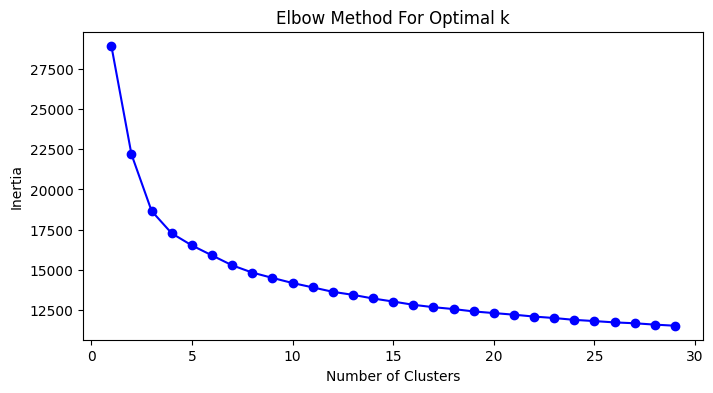

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
from sklearn.cluster import KMeans
import numpy as np

# Convert the list of embedding arrays into a 2D array
embeddings = np.vstack(post_df['post_embeddings'].values)

inertias = []
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10).fit(embeddings)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(range(1, 30), inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Given the plot, we start with k=10 as a reasonable guess
# Apply KMeans clustering base on the Elbow Method, K=10
kmeans = KMeans(n_clusters=10, random_state=42)
post_df['cluster'] = kmeans.fit_predict(embeddings)

In [21]:
import pickle

# Assuming 'kmeans' is your trained KMeans model
with open('kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)



---



In [22]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import pickle


**Preparing the data for the model:**

In [23]:
def flatten_if_nested(embedding):
  if len(embedding) == 1:
      return embedding[0]
  # If it's already a 1D list or a numpy array, return it as is
  return embedding

# Flatten the embeddings and stack them horizontally
X_headline_embeddings = np.array(list(map(flatten_if_nested, post_df['headline_embeddings'].tolist())))
X_about_embeddings = np.array(list(map(flatten_if_nested, post_df['about_embeddings'].tolist())))
X_post_embeddings = np.array(list(map(flatten_if_nested, post_df['post_embeddings'].tolist())))
X_embeddings = np.hstack((X_headline_embeddings, X_about_embeddings, X_post_embeddings))


# Prepare other scalar features
scalar_feature_names = ['followers', 'number_of_images', 'sentiment', 'word_count',
                        'line_count', 'hashtag_count', 'url_count', 'adjective_count',
                        'total_keyword_count', 'flesch_score', 'gunning_fog',
                        'coleman_liau', 'combined_score', "unique_keyword_count", "ellipsis"]
X_scalar = post_df[scalar_feature_names].values

# One-hot encode categorical features
categorical_feature_names = ['industryName', 'topic', 'cluster', "geoLocationName"]
one_hot_encoder = OneHotEncoder()
X_categorical = one_hot_encoder.fit_transform(post_df[categorical_feature_names]).toarray()
# Save the encoder
with open('one_hot_encoder.pkl', 'wb') as encoder_file:
    pickle.dump(one_hot_encoder, encoder_file)

# Combine all features
X = np.hstack((X_embeddings, X_scalar, X_categorical))
y = post_df['popularity_score'].values


# Feature names: embeddings + scalar features + one-hot encoded feature names
embedding_feature_names = ['headline_embedding_{}'.format(i) for i in range(X_headline_embeddings.shape[1])] + \
                          ['about_embedding_{}'.format(i) for i in range(X_about_embeddings.shape[1])] + \
                          ['post_embedding_{}'.format(i) for i in range(X_post_embeddings.shape[1])]


one_hot_feature_names = one_hot_encoder.get_feature_names_out(categorical_feature_names).tolist()
feature_names = embedding_feature_names + scalar_feature_names + one_hot_feature_names


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [24]:
def evaluate_model(y_true, y_pred):
  metrics = {
    'Accuracy': accuracy_score(y_true, y_pred),
    'Precision': precision_score(y_true, y_pred, average='binary'),
    'Recall': recall_score(y_true, y_pred, average='binary'),
    'F1 Score': f1_score(y_true, y_pred, average='binary')
  }
  return metrics

**Random Forest:**

In [25]:
# # Initialize the RandomForestClassifier
rf_classifier = RandomForestClassifier(
  n_estimators=500,
  max_depth=25,
  min_samples_split=5,
  min_samples_leaf=25,
  max_features='sqrt',
  bootstrap=True,
  random_state=42,
  class_weight='balanced',
)

# # Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
results = evaluate_model(y_test, y_pred)
for metric, value in results.items():
  print(f'{metric}: {value:.4f}')


Accuracy: 0.8571
Precision: 0.3864
Recall: 0.4554
F1 Score: 0.4180


**Logistic regression:**

In [26]:
# Initialize the LogisticRegression model
logistic_model = LogisticRegression(max_iter=1000, solver = "liblinear", C=1, random_state=42, class_weight = "balanced" )

# Train the model
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred = logistic_model.predict(X_test)

# Evaluate the model
results = evaluate_model(y_test, y_pred)
for metric, value in results.items():
  print(f'{metric}: {value:.4f}')


Accuracy: 0.8018
Precision: 0.2986
Recall: 0.5625
F1 Score: 0.3901


In [27]:
import pickle

# Save the model
with open('logistic_model.pkl', 'wb') as file:
    pickle.dump(logistic_model, file)

# Calculate the percentiles for the entire dataset
percentiles = np.percentile(X, [20, 40, 60, 80], axis=0)

# Save the percentiles for inference
with open('percentiles.pkl', 'wb') as file:
    pickle.dump(percentiles, file)

**Model Selection:**

Considered both RandomForestClassifier and LogisticRegression for the task.
Chose Logistic Regression over RandomForest for:
Providing a "score per post."
Handling imbalanced labels effectively.
Focusing on the F1 score due to label imbalance.
Despite RandomForest yielding a slightly higher F1 score, the difference was not deemed significant.

**Feature Selection:**

Identified less contributing features: multiple_exclamation_marks, keyword_diversity, keyword_diversity.
Decided to exclude these features from the model.

**Hyperparameter Tuning:**

Utilized GridSearchCV to find optimal hyperparameters.
Explored various values for:
Regularization strength (C).
Optimization algorithms (solver).
Number of iterations for convergence (max_iter).
Achieved the best results with:
max_iter=1000, solver="liblinear", C=0.5.
Handling Imbalanced Data:

Used class weights (class_weight="balanced") to address label imbalance in the dataset.

**Model Evaluation:**

Trained the Logistic Regression model with the selected hyperparameters.
Made predictions on the test set.
Evaluated the model using metrics like accuracy, precision, recall, and F1 score.
Focused on the F1 score due to its importance in imbalanced datasets.

**Comparison with RandomForest:**

Initially tried RandomForestClassifier, and while it yielded a slightly higher F1 score compared to Logistic Regression, the difference was not deemed significant.
Opted for Logistic Regression due to its ability to provide individual post scores and its effectiveness in handling imbalanced data.

Scalar feature coefficients

In [28]:
# Get coefficients from the trained model
coefficients = logistic_model.coef_[0]

# Map the scalar feature names to their corresponding coefficients
scalar_feature_importances = {feature: coef for feature, coef in zip(feature_names, coefficients) if feature in scalar_feature_names}

# Sort the scalar features by the absolute value of their coefficients for interpretability
sorted_scalar_feature_importances = sorted(scalar_feature_importances.items(), key=lambda x: abs(x[1]), reverse=True)

# Display the sorted scalar feature importances
for feature, importance in sorted_scalar_feature_importances:
    print(f"{feature}: {importance}")


adjective_count: 0.9002570806039034
number_of_images: 0.6402582771468931
followers: 0.567466644268043
word_count: -0.5035388341485818
total_keyword_count: -0.45664598835203796
coleman_liau: -0.37533621202926226
unique_keyword_count: 0.3731508887919956
flesch_score: -0.2183159198349953
url_count: -0.16264407006969953
ellipsis: -0.1324459057761564
combined_score: 0.10470817092376691
hashtag_count: -0.09525302951023641
line_count: 0.07491796659019136
gunning_fog: 0.044633652293924145
sentiment: 0.01739084002405256




---



**inference:**

In [29]:
# Get the coefficients from the logistic regression model
coefficients = logistic_model.coef_[0]

# Create a dictionary mapping feature names to their coefficients
feature_coefficients = scalar_feature_importances = {feature: coef for feature, coef in zip(feature_names, coefficients) if feature in scalar_feature_names}

# Function to categorize the value into percentile bins
def get_percentile_bin(percentiles ,value, feature_idx):
  feature_percentiles = percentiles[:, feature_idx]
  if value <= feature_percentiles[0]:
    return "very low"
  elif value <= feature_percentiles[1]:
    return "low"
  elif value <= feature_percentiles[2]:
    return "medium"
  elif value <= feature_percentiles[3]:
    return "high"
  else:
    return "very high"

# Categorize features
general_features = ['followers', 'number_of_images']
post_improvement_features = [
  'sentiment', 'word_count', 'line_count', 'hashtag_count', 'url_count',
  'adjective_count', 'total_keyword_count', 'flesch_score', 'gunning_fog',
  'coleman_liau', 'combined_score', 'unique_keyword_count', 'ellipsis'
]

# Select an example from the test set
example_idx = 5
example = X_test[example_idx]
post_instance_score = X_test[example_idx].reshape(1, -1)  # Reshape to 2D array
current_score = logistic_model.predict_proba(post_instance_score)[0][1]
print(f"score for {example_idx}: {current_score}")

# Iterate through each feature to generate recommendations
recommendations = []
for idx, feature in enumerate(scalar_feature_names):
  if feature in feature_coefficients:
    current_value = example[idx]
    coef = feature_coefficients[feature]
    current_bin = get_percentile_bin(percentiles, current_value, idx)

    # Recommendations for general features for broader strategy
    if feature in general_features:
      recommendation = f"To improve future posts' performance, "
      if coef > 0:
        recommendation += f"increasing '{feature}' (currently '{current_bin}') can be beneficial. "
        recommendation += "Consider strategies to enhance this feature over time."
      else:
        recommendation += f"decreasing '{feature}' (currently '{current_bin}') can be beneficial. "
        recommendation += "Consider strategies to manage or mitigate this feature's influence."
    # Recommendations for content-related features for immediate post improvement
    else:
      recommendation = f"For immediate post improvement, "
      if coef > 0:
        if current_bin in ["very low", "low", "medium"]:
          recommendation += f"increasing '{feature}' may have a positive impact. "
        else:
          recommendation += f"'{feature}' is already at a beneficial level. "
      else:
        if current_bin in ["high", "very high", "medium"]:
          recommendation += f"reducing '{feature}' may improve performance. "
        else:
          recommendation += f"'{feature}' is already at a beneficial level. "

    recommendations.append(recommendation)

# Print recommendations
for rec in recommendations:
    print(rec)



score for 5: 0.23571745445306452
To improve future posts' performance, increasing 'followers' (currently 'very low') can be beneficial. Consider strategies to enhance this feature over time.
To improve future posts' performance, increasing 'number_of_images' (currently 'very low') can be beneficial. Consider strategies to enhance this feature over time.
For immediate post improvement, increasing 'sentiment' may have a positive impact. 
For immediate post improvement, 'word_count' is already at a beneficial level. 
For immediate post improvement, increasing 'line_count' may have a positive impact. 
For immediate post improvement, reducing 'hashtag_count' may improve performance. 
For immediate post improvement, reducing 'url_count' may improve performance. 
For immediate post improvement, increasing 'adjective_count' may have a positive impact. 
For immediate post improvement, 'total_keyword_count' is already at a beneficial level. 
For immediate post improvement, reducing 'flesch_score

In [30]:
# !pip install lime


In [31]:
# from lime import lime_tabular

# # Step 1: Generate explanation using all features
# explainer = lime_tabular.LimeTabularExplainer(
#     training_data=X_train,
#     feature_names=feature_names,  # Use all feature names
#     class_names=['bad post', 'good post'],
#     mode='classification'
# )

# post_index = 9
# post_instance = X_test[post_index]
# post_instance_score = X_test[post_index].reshape(1, -1)  # Reshape to 2D array
# current_score = logistic_model.predict_proba(post_instance_score)[0][1]
# print(f"score for {post_index}: {current_score}")

# explanation = explainer.explain_instance(
#     data_row=post_instance,
#     predict_fn=logistic_model.predict_proba,  # Use the full model
#     num_features=len(feature_names)  # Consider all features for generating explanation, then filter
# )

# # Step 2: Filter the explanation
# # Get explanation as list and filter to keep only scalar features
# exp_list = explanation.as_list()
# scalar_exp_list = []
# for exp in exp_list:
#   for feature in scalar_feature_names:
#     if feature in exp[0]:
#       scalar_exp_list.append(exp)

# # Step 3: Display the filtered explanation
# lime_results = {}
# print("Scalar Feature Contributions:")
# for feature, contribution in scalar_exp_list:
#   lime_results[feature] = contribution
#   print(f"{feature}: {contribution}")


**Visualizations:**

In [32]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

General:

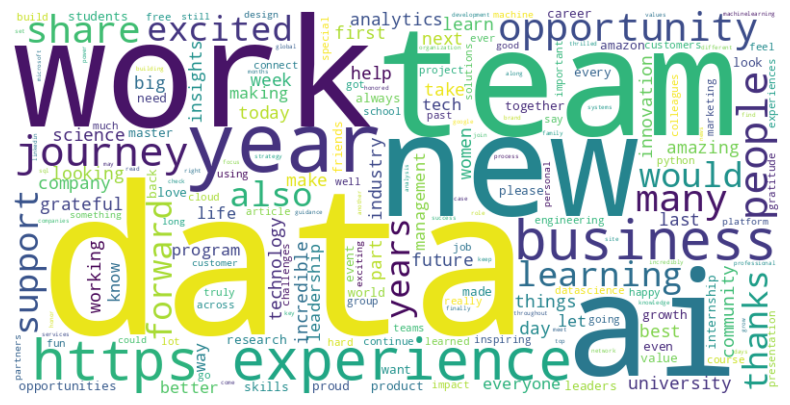

In [33]:
def generate_word_cloud(dataframe, popularity_score=1.0):
  # Update stopwords list with custom stopwords
  custom_stopwords = ['one', 'time', 'great', 'like', 'see', 'en', 'la', 'que',
                      'el', "de", "los", "para", "las", "una", "im", "un", "con", "es","tu", "se","1", "get", "use","one", "thank", "us"]
  all_stopwords = set(stopwords.words('english')).union(set(custom_stopwords)).union(set(custom_stopwords))

  # Filter the DataFrame to include only rows where the post is classified as 'good'
  good_posts = dataframe[dataframe['popularity_score'] == popularity_score]['text'].tolist()

  # Joining the 'text' column values of good posts into a single text string
  text = " ".join(good_posts)

  # Tokenization and preprocessing
  tokens = word_tokenize(text.lower())
  words = [word for word in tokens if word.isalpha() and word not in all_stopwords]

  # Frequency distribution
  freq_dist = FreqDist(words)

  # Generating the word cloud
  wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(freq_dist)

  # Displaying the word cloud
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.show()

# Example usage:
generate_word_cloud(post_df, popularity_score=1.0)


Visualizations of the model:

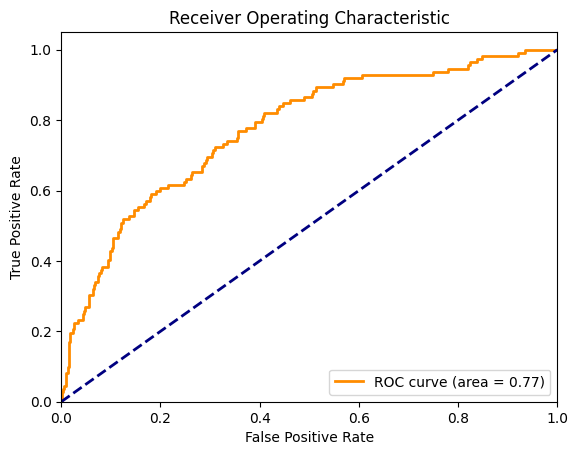

In [34]:
def plot_roc_auc(model, X_test, y_test):
  # Get the probabilities of the positive class
  y_proba = logistic_model.predict_proba(X_test)[:, 1]

  # Calculate ROC curve and ROC area
  fpr, tpr, thresholds = roc_curve(y_test, y_proba)
  roc_auc = auc(fpr, tpr)

  # Plotting the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic')
  plt.legend(loc="lower right")
  plt.show()

# Example usage with logistic regression model
plot_roc_auc(logistic_model, X_test, y_test)


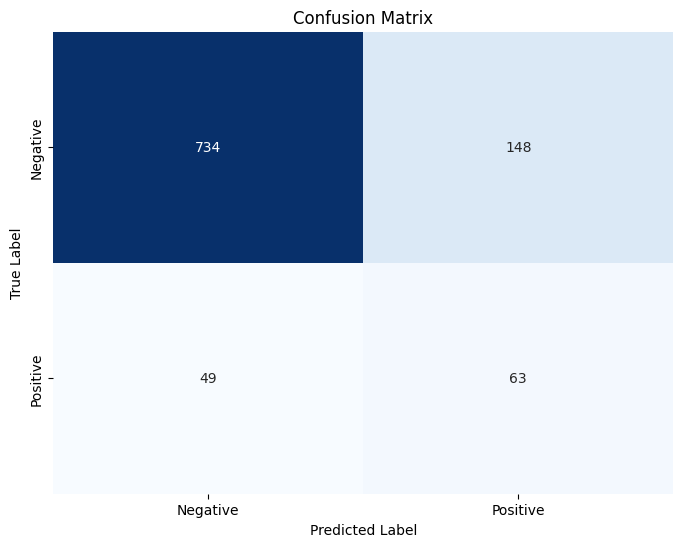

In [35]:
def plot_confusion_matrix(model, X_test, y_test):
  # Make predictions
  y_pred = model.predict(X_test)

  # Generate confusion matrix
  cm = confusion_matrix(y_test, y_pred)

  # Plot confusion matrix as heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
              xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
  plt.title('Confusion Matrix')
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.show()

# Example usage:
plot_confusion_matrix(logistic_model, X_test, y_test)


Inference for one example using the LIME:

In [36]:
# import matplotlib.pyplot as plt

# def plot_feature_contributions(scalar_exp_list):
#   # Extracting feature names and their contributions
#   features, contributions = zip(*scalar_exp_list)

#   # Creating the plot
#   plt.figure(figsize=(8, 6))
#   colors = ['green' if c > 0 else 'red' for c in contributions]
#   plt.barh(features, contributions, color=colors)
#   plt.xlabel('Feature Contribution')
#   plt.title('Scalar Feature Contributions')
#   plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature on top
#   plt.show()

# # Example usage (using dummy data for illustration):
# plot_feature_contributions(scalar_exp_list)


Showing the effect of the coefficients of the model:

In [37]:
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 10.0 MB/s eta 0:00:00


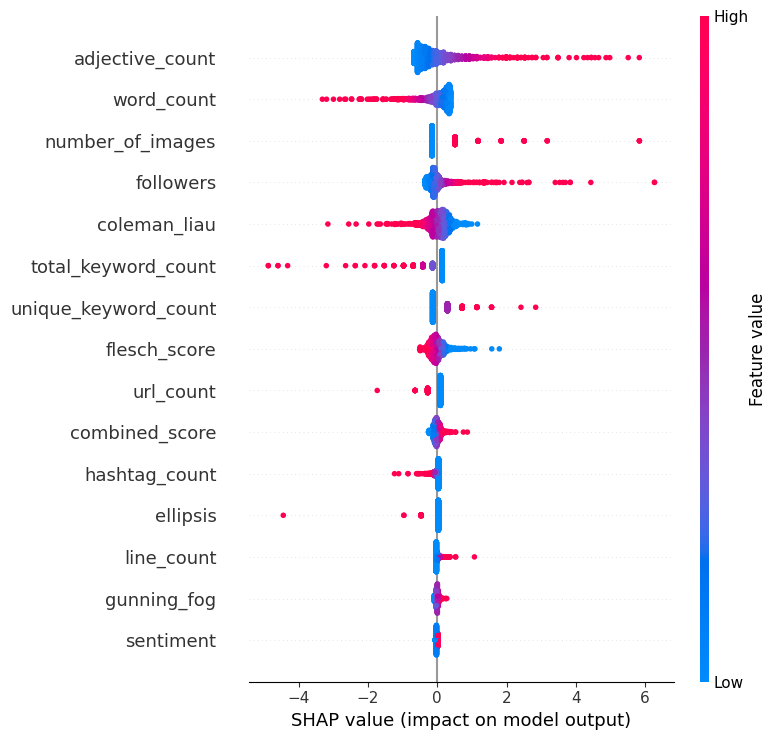

In [38]:
import shap

# Initialize the SHAP explainer with the logistic regression model and the training data
explainer = shap.Explainer(logistic_model, X_train)

# Compute SHAP values for the test set
shap_values_all = explainer(X_test)

# Now, you want to visualize the impact of scalar features only.
# First, identify the indices of scalar features in your dataset
scalar_feature_indices = [idx for idx, feature in enumerate(feature_names) if feature in scalar_feature_names]

# Extract SHAP values for scalar features only
scalar_shap_values = shap_values_all[:, scalar_feature_indices]

# Convert X_test to a DataFrame for better visualization
X_test_df = pd.DataFrame(X_test, columns=feature_names)

# Create a summary plot for the scalar features
shap.summary_plot(scalar_shap_values.values, X_test_df[scalar_feature_names])



"Each dot on the SHAP summary plot corresponds to a feature's effect on the predictive model's output for an individual post. The position on the horizontal axis shows the magnitude and direction of the feature's impact: dots to the right of zero increase the likelihood of a post being rated as 'good,' while dots to the left decrease that likelihood.

The 'adjective_count' feature is at the top of the plot, which suggests it has a substantial influence on the model’s decisions. High values of 'adjective_count' (indicated by red dots) generally push the model to predict a post as 'good.' Conversely, lower counts (blue dots) might lead to a neutral or negative impact on the model's output.

Directly below, 'number_of_images' also shows a strong positive influence when its value is high, contributing to a post's favorable rating. Other features, such as 'word_count' and 'followers,' appear to have mixed effects based on their values, as indicated by the spread of dots across the horizontal axis.

Negative SHAP values for features like 'url_count' and 'sentiment' indicate that higher values for these features might contribute negatively to a post's score, suggesting that an increase in URLs or certain sentiment expressions could be detrimental according to the model's learned patterns.

Lastly, the overlapping of points around the zero line for features like 'gunning_fog' and 'hashtag_count' may indicate that these features have a variable impact that could depend on the context of the post or interaction with other features.

This plot provides a comprehensive view of how different aspects of a post contribute to its predicted success, highlighting areas for potential improvement to enhance the post's engagement or reception based on the model's learned associations."